# 1 Import bibliotecas

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 2 Regras de negócio

## 2.1 Lead time fornecedor
- Assumindo um conhecimento prévio sobre a distribuição do lead time do fornecedor (distribuição triangular em torno do lead max, min e mais provável)
- Os fornecedores geralmente trabalham com tempo min, max e o mais provável
- Assumiremos distribuição triangula, portanto!

## 2.2 Estoque mínimo
- Estoque mínimo definido com o nível em estoque que uma vez atingido deve ser efetuado uma compra imediatamente!

## 2.3 A quantidade a ser comprada
- É definido de acordo com a política de compra, geralmente estima-se a quantidade de produtos a ser comprado de acordo com o estoque atual a demanda e o lead time do fornecedor. simplificaremos com um único parametro n_dias_reabast

- Assim que for identificada a necessidade de compra esse parâmetro calculará a qtd a ser comprada baseado na demanda para suprir n_dias_reabast.
 

# 3 Simulação de Monte Carlo
#### Orientações: 
- **n_dias_reabast:** orienta-se reabastecer de acordo com t_max_fornecedor e t_min_fornecedor, o reabastecimento tem q suprir pelo menos o lead time do fornecedor
- **qtd_comprada_t0:** orienta-se definir de acordo com a politica de compra atual, usualmente entre  (media_demanda_t0 * t_max_fornecedor) e (media_demanda_t0 * t_min_fornecedor), a quantidade comprada tem que ser suficiente para cubrir pelo menos a demanda durante o lead time do fornecedor
- **estoque_minimo:** orienta-se definir entre (media_demanda_t0 * t_max_fornecedor) e (media_demanda_t0 * t_min_fornecedor), a decisão de compra tem que ocorrer em tempo habil para o fornecedor entregar!
- **estoque em t_0:** tem que ser maior que estoque mínimo, ou orienta-se somar seu estoque atual + quantidade em compras em aberto já que não temos parametros de inicialização para compras em aberto, caso esteja abaixo do estoque_minimo então será realizado uma compra no primeiro dia de simulação!
- **preco_unitario_max e preco_unitario_min:** o quanto pode-se barganhar no preço com fornecedor a depender da qtd_comprada
- **elasticidade_preco_demanda:** já estimada e estudada previamente (em função da disponibilidade de substitutos, bens de necessidade ou luxo, comprometimento da renda ao comprar o item)

## 3.1 Função simulação

In [252]:
def simulacao_estoque_montecarlo(num_simulacoes,        ## Var simulação
                         n_dias,                        ## Var simulação


                         media_demanda_t0,              ## Var inicialização da simulação t=0 - Média demanda
                         desvio_padrao_demanda_t0,      ## Var inicialização da simulação t=0 - Desvio padrão demanda
                         qtd_comprada_t0,               ## Var inicialização da simulação t=0 - Qtd comprada ultima compra
                         estoque_t0,                    ## Var inicialização da simulação t=0 - Nível de estoque

                         preco_unitario_max,            ## Var Fornecedor: Definidos pelo fornecedor se comprar só 1
                         preco_unitario_min,            ## Var Fornecedor: Definidos pelo fornecedor descontos extras caso compre o a partir de um máximo definido
                         tempo_reposicao_min,           ## Var Fornecedor: tempo mínimo para entrega
                         tempo_reposicao_max,           ## Var Fornecedor: tempo máximo para entrega
                         tempo_reposicao_most_likely,   ## Var Fornecedor: tempo mais provavel para entrega
                         b,                             ## Var fornecedor: controla taxa de decaimento do preço em detrimento da qtd_comprada
                        
                         elasticidade_preco_demanda,    ## Var negócio: Elasticidade preco demanda observado para o produto
                         n_dias_reabast,                ## Var negócio: Cada compra terá que reabastecer a demanda prevista nos proximos n_dias_reabast
                         estoque_minimo):               ## Var negócio: Estoque mínimo para ser triggado uma checagem para realização de uma compra.
                                       

    ## Check orientações e alertas:
    if n_dias_reabast < tempo_reposicao_min or n_dias_reabast > tempo_reposicao_max:
        print(f'parâmetro n_dias_reabast = {n_dias_reabast} está fora do intervalo tempo_reposicao_min = {tempo_reposicao_min} e tempo_reposicao_max = {tempo_reposicao_max}')
    if qtd_comprada_t0 < media_demanda_t0 * tempo_reposicao_min or qtd_comprada_t0 > media_demanda_t0 * tempo_reposicao_max:
        print(f'parâmetro qtd_comprada_t0 = {qtd_comprada_t0} está fora do intervalo {media_demanda_t0 * tempo_reposicao_min} e {media_demanda_t0 * tempo_reposicao_max}')
    if estoque_minimo < media_demanda_t0 * tempo_reposicao_min or estoque_minimo > media_demanda_t0 * tempo_reposicao_max:
        print(f'parâmetro estoque_minimo = {estoque_minimo} está fora do intervalo {media_demanda_t0 * tempo_reposicao_min} e {media_demanda_t0 * tempo_reposicao_max}')
    if estoque_t0 < estoque_minimo:
        print(f'Alerta: parâmetro estoque_t0 = {estoque_t0} foi inicializado abaixo do estoque_minimo, orienta-se somar o estoque atual com as compras em aberto! - há risco de stockout logo no inicio da simulação!')
        print('iniciando simulação com trigger de compra no primeiro dia de simulação!')
    



    ## Inicializando os resultado da simulação
    df_resultados = pd.DataFrame(columns = ['n_simulacao', 'n_dia','estoque_dia','estoque_min', 'demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'preco_compra', 'previsao_demanda_t_menosum', 'previsao_demanda_t',' qtd_comprada_dia','lead_time_forn_dia','dia_prox_reabastecimento', 'flag_houve_stockout', 'qtd_compra_acumulada'])

    ## Variaveis elasticidade preco vs demanda
    ## b = Decaimento
    a = preco_unitario_max-preco_unitario_min  ## Amplitude
    c = 1 ## A partir de qual valor há decaimento exponencial = 1
    d = preco_unitario_min ## valor minimo (assintota)

    ## Calculando preco unitário em t0
    preco_unitario_t0 = a*np.exp(b*(qtd_comprada_t0-c)) + d



    # Roda varias simulações
    for n_sim in range(1, num_simulacoes+1):

        ################### Inicialização de variaveis ###################
        ## Inicializa variavel e demanda
        demanda_t_menos_um = media_demanda_t0
        media_demanda_t = media_demanda_t0
        desvio_padrao_demanda_t = desvio_padrao_demanda_t0

        ## Inicializa variavel de preco pago na ultima compra
        preco_unitario_t = preco_unitario_t0

        ## Inicializa o estoque para os niveis atuais no começo da simulação
        estoque = estoque_t0

        ## Inicializa o dataframe de compras em aberto
        df_compras = pd.DataFrame(columns=['qtd','leadtime','n_dia','n_dia_chegada'])
        
        ## Inicializa variavel de qtd_compra_acumulada
        qtd_compra_acumulada = 0


        # Percorre cada dia de simulação
        for dia in range(n_dias):

            # Simula a demanda para o dia da simulação, baseado na distribuição da demanda do dia anterior (d-1)
            demanda_do_dia = np.random.normal(media_demanda_t, desvio_padrao_demanda_t, 1)
            demanda_do_dia = demanda_do_dia.astype(int)  # Convertendo para inteiros
            demanda_do_dia = demanda_do_dia[0]

            ## Iniciando o dia da simulação sem reabastecimento e sem compra e ainda sem stockout
            flag_reabasteceu = 0
            flag_comprou = 0
            qtd_comprada_dia = np.nan
            tempo_reposicao_dia = np.nan
            n_dia_chegada = np.nan
            qtd_reabastecida = np.nan
            flag_houve_stockout = 0

            ################### Efetua Reposição de produtos ###################
            if dia in df_compras.n_dia_chegada.unique().tolist():

                df_a_reabastecer = df_compras[df_compras['n_dia_chegada']==dia]
                qtd_reabastecida = df_a_reabastecer.qtd.sum()

                ## Atualiza estoque reabastecido
                estoque = estoque + qtd_reabastecida

                ## Atualiza o dataframe de compras em aberto após reabastecimento
                df_compras = df_compras[df_compras['n_dia_chegada']!=dia]

                ## Atualiza quantidade de compra acumulada devido ao reabastecimento
                qtd_compra_acumulada = df_compras.qtd.sum()

                ## Atualiza flag reabastecimento
                flag_reabasteceu = 1

                ################### Assim que o produto chega, também atualiza o preço e a demanda dada a qtd_comprada (ou reabastecida nesse caso)!! ###################
                ### Novo preco
                preco_unitario_t_menosum = preco_unitario_t
                preco_unitario_t = a*np.exp(b*(qtd_reabastecida-c)) + d

                ## Nova demanda dado elasticidade preco demanda
                demanda_t_menos_um = media_demanda_t


                ## Atualiza demanda de acordo com a elasticidade preco-demanda, caso for desconhecida não atualiza!
                if elasticidade_preco_demanda != None:
                    ## var preco aumentou -> diminui demanda // var preco diminui-> aumenta demanda
                    var_percentual_preco = (preco_unitario_t_menosum - preco_unitario_t)/preco_unitario_t_menosum
                    var_percentual_demanda = elasticidade_preco_demanda * var_percentual_preco
                    var_total_demanda = media_demanda_t * var_percentual_demanda

                    media_demanda_t = media_demanda_t + var_total_demanda
                    
                    ### Novo desvpad demanda: Assumiremos que desvpad irá decair ou aumentar na mesma proporção que a demanda em d / d-1
                    desvio_padrao_demanda_t = desvio_padrao_demanda_t * (media_demanda_t / demanda_t_menos_um)
            


            # Reduz o estoque baseado na demanda
            estoque = estoque - demanda_do_dia


            ## Corrige o estoque para 0 pois nao pode ser negativo
            if estoque < 0:
                estoque = 0

            ################### Verifica condição de stockout ###################
            if estoque == 0:
                flag_houve_stockout = 1


            ################### Checa condições de compra  ###################

            # Inicializa/reseta variaveis de compra
            comprar = False
            qtd_comprada_dia = 0
            n_dia_chegada = np.nan
            qtd_comprada_historico = 0
            qtd_comprada_dia = 0
            tempo_reposicao_dia = 0
            
            # Caso estoque atinja o estoque mínimo inicializa checagens para decisão de compra
            if estoque < estoque_minimo:


                ## Caso ja tenha compras em aberto então checar outras condições (se a compra será suficiente por ex)
                if len(df_compras) > 0:

                    ## Checa se o pedido de compra em aberto será suficiente para superar o estoque mínimo na data prevista da entrega
                    ## Caso haja multiplas compras checa a qtd total comprada e o nível de estoque na data prevista de entrega mais distante
                    ## A estimativa é realizada baseada na demanda do dia anterior (d-1)
                    qtd_comprada_historico = df_compras.qtd.sum()
                    n_dia_chegada = df_compras.n_dia_chegada.max()
                    estimativa_estoque_data_entrega_max = estoque - media_demanda_t * (n_dia_chegada - dia) + qtd_comprada_historico

                    #print(f' no dia {dia} o estoque está em {estoque} - há {qtd_comprada_historico} produtos para chegar em {n_dia_chegada} - nesse dia estimamos que o estoque estará em {estimativa_estoque_data_entrega_max}')


                    ## Caso as compras não tenham sido suficientes para superar o estoque mínimo então efetuar nova compra
                    if estimativa_estoque_data_entrega_max < estoque_minimo:
                    
                        comprar = True
                        flag_comprou = 1

                    else:
                        comprar = False

                ## Caso nao tenha compras em aberto então é necessário comprar!!        
                else:
                    comprar = True
                    flag_comprou = 1


                ################### Efetua a compra ###################
                if comprar == True:


                    # Simula o lead time com distribuição triangular
                    tempo_reposicao_dia = np.random.triangular(
                        tempo_reposicao_min,
                        tempo_reposicao_most_likely,
                        tempo_reposicao_max)
                    
                    tempo_reposicao_dia = int(tempo_reposicao_dia) ## em dias inteiros
                    n_dia_chegada = dia + tempo_reposicao_dia ## Calcula qtd de dias até a reposição
                    
                    
                    ## a Previsao de chegada para essa compra deve ser igual ou superior a previsao de chegada da compra mais próxima a chegar (caso houver)
                    ## Lógica: Uma compra efetuada depois não pode chegar antes de uma compra efetuada anteriormente
                    ##if len(df_compras)>0:
                        ##n_dia_prox_entrega = int(df_compras.iloc[-1,:].n_dia_chegada)      ## data da entrega da ultima compra
                        ##tempo_resposicao_min_aceitavel = n_dia_prox_entrega - dia     ## Tempo de reposição mínimo aceitável para cumprir essa condição
                    ##else:
                        ##n_dia_prox_entrega = 0

                    ## Corrige lead time fornecedor e dia estimado para chegada dos produtos
                    ## Lógica: Uma compra efetuada depois não pode chegar antes de uma compra efetuada anteriormente
                    ##if n_dia_chegada < n_dia_prox_entrega:
                        ##n_dia_chegada = n_dia_prox_entrega  ## No cenário mais favorável o pedido chegará junto com outro pedido anteriormente!! e não antes!
                        ##tempo_reposicao_dia = tempo_resposicao_min_aceitavel


                    # O pedido é efetuado baseado na demanda do dia anterior (d-1)
                    ## na data de chegada do pedido o estoque tem que ser suficiente para abastecer n dias de reabastecimento
                    qtd_comprada_dia = media_demanda_t * (n_dias_reabast)
                    qtd_comprada_dia = np.ceil(qtd_comprada_dia) # Convertendo para inteiro arredondado pra cima


                    ## Armazena os dados de compra
                    df_compra_dia = pd.DataFrame(np.array([[qtd_comprada_dia,tempo_reposicao_dia,dia,n_dia_chegada ]]), columns=['qtd','leadtime','n_dia','n_dia_chegada'])
                    df_compras = pd.concat([df_compras, df_compra_dia], ignore_index=True)
            
                    
                    ## Atualiza quantidade de compra acumulada devido ao reabastecimento
                    qtd_compra_acumulada = df_compras.qtd.sum()

            ################### Armazena os resultados da simulação diaria  ###################

            df_resultados_dia = pd.DataFrame(np.array([[n_sim, dia, estoque, estoque_minimo, demanda_do_dia, flag_reabasteceu, qtd_reabastecida, flag_comprou, preco_unitario_t, demanda_t_menos_um, media_demanda_t, qtd_comprada_dia, tempo_reposicao_dia, n_dia_chegada, flag_houve_stockout, qtd_compra_acumulada ]]), 
                                            columns = ['n_simulacao', 'n_dia','estoque_dia','estoque_min', 'demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'preco_compra', 'previsao_demanda_t_menosum', 'previsao_demanda_t',' qtd_comprada_dia','lead_time_forn_dia','dia_prox_reabastecimento', 'flag_houve_stockout', 'qtd_compra_acumulada'])
            df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)


            ################### Report Status     ###################
            
            ##print(f'simulacao = {n_sim} - dia = {dia} - estoque = {estoque}')

    return df_resultados

## 3.2 Função visualização estoque

In [194]:
def plot_simulacoes(df_resultados, id_sim):

    # Obter lista de simulações
    ##lista_simulacoes = df_resultados['n_simulacao'].unique()

    # Criar o gráfico de linha para cada simulação
    plt.figure(figsize=(12, 8))


    # Manter um controle para evitar duplicatas na legenda
    compra_legenda_adicionada = False
    reabastecimento_legenda_adicionada = False
    stockout_legenda_adicionada = False


    for simulacao in [id_sim]:
        df_simulacao = df_resultados[df_resultados['n_simulacao'] == simulacao]

        # pontos cinzas em dias de compras
        df_compras = df_simulacao[df_simulacao['flag_comprou'] == 1]
        if not compra_legenda_adicionada:
            # Só adicionar a legenda uma vez para compras
            plt.scatter(df_compras['n_dia'], df_compras['estoque_dia'], color='gray', s=100, marker='o', label='Compra')
            compra_legenda_adicionada = True
        else:
            plt.scatter(df_compras['n_dia'], df_compras['estoque_dia'], color='gray', s=100, marker='o')

        # pontos vermelhos em dias de stockouts
        df_stockout = df_simulacao[df_simulacao['flag_houve_stockout'] == 1]
        if not stockout_legenda_adicionada:
            # Só adicionar a legenda uma vez para stockouts
            plt.scatter(df_stockout['n_dia'], df_stockout['estoque_dia'], color='red', s=100, marker='o', label='Stockout')
            stockout_legenda_adicionada = True
        else:
            plt.scatter(df_stockout['n_dia'], df_stockout['estoque_dia'], color='red', s=100, marker='o')

        # pontos azuis em dias de reabastecimentos
        df_reabastecimento = df_simulacao[df_simulacao['flag_reabasteceu'] == 1]
        if not reabastecimento_legenda_adicionada:
            # Só adicionar a legenda uma vez para reabastecimento
            plt.scatter(df_reabastecimento['n_dia'], df_reabastecimento['estoque_dia'], color='blue', s=100, marker='o', label='Reabastecimento')
            reabastecimento_legenda_adicionada = True
        else:
            plt.scatter(df_reabastecimento['n_dia'], df_reabastecimento['estoque_dia'], color='blue', s=100, marker='o')


        # Gráfico de linha para o estoque diario
        #plt.plot(df_simulacao['n_dia'], df_simulacao['estoque_dia'])
        plt.plot(df_simulacao['n_dia'], df_simulacao['estoque_dia'], label=f'Simulação {int(simulacao)}')


        # Ao final de cada grafico de linha adicionar um identificador da simulação
        ultimo_dia = df_simulacao['n_dia'].iloc[-1]
        estoque_final = df_simulacao['estoque_dia'].iloc[-1]
        
        # Adiciona uma anotação com uma flecha para a última posição do gráfico de linha
        #plt.annotate(
            #f'Simulação = {int(simulacao)}',
            #xy=(ultimo_dia, estoque_final), 
            #xytext=(ultimo_dia + 5, estoque_final), 
            #arrowprops=dict(facecolor='black', arrowstyle='->')
        #)


    # Adicionar a legenda
    plt.legend(loc='best')

    # Ajustes no grafico
    plt.xlabel('Dia')
    plt.ylabel('Nível de Estoque')
    plt.title(f'Num_Simulação - {id_sim}')
    plt.grid(True)  
    plt.show() 

## 3.3 Simulação probabilidade de Stockout
-  A probabilidade será definida em numero de simulações em que houve stockout / numero total simulações

In [195]:
def probabilidade_stockout(df_resultados):

    return df_resultados[ (df_resultados['flag_houve_stockout']==1) ].n_simulacao.nunique() / df_resultados.n_simulacao.nunique()

## 3.4 Simulação

#### Orientações: 
- **n_dias_reabast:** orienta-se reabastecer de acordo com t_max_fornecedor e t_min_fornecedor, o reabastecimento tem q surprir pelo menos o lead time do fornecedor
- **qtd_comprada_t0:** ´preencher com a quantidade comprada na ultima compra, orienta-se definir de acordo com a politica de compra atual, usualmente entre  (media_demanda_t0 * t_max_fornecedor) e (media_demanda_t0 * t_min_fornecedor), a quantidade comprada tem que ser suficiente para cubrir pelo menos a demanda durante o lead time do fornecedor
    - A partir dessa variável e dos preços max min e mais provável, estimamos o preço pago em t0.
- **estoque_minimo:** orienta-se definir entre (media_demanda_t0 * t_max_fornecedor) e (media_demanda_t0 * t_min_fornecedor), a decisão de compra tem que ocorrer em tempo habil para o fornecedor entregar!
- **estoque em t_0:** tem que ser maior que estoque mínimo, ou orienta-se somar seu estoque atual + quantidade em compras em aberto já que não temos parametros de inicialização para compras em aberto, caso esteja abaixo do estoque_minimo então será realizado uma compra no primeiro dia de simulação!
- **preco_unitario_max e preco_unitario_min:** o quanto pode-se barganhar no preço com fornecedor a depender da qtd_comprada
- **elasticidade_preco_demanda:** já estimada e estudada previamente (em função da disponibilidade de substitutos, bens de necessidade ou luxo, comprometimento da renda ao comprar o item) - Caso seja desconhecido preencher como None, então a demanda não irá variar de acordo com a quantidade comprada e preço

In [199]:
df_resultados = simulacao_estoque_montecarlo(
                         num_simulacoes = 250,                  ## Var simulação
                         n_dias = 180,                          ## Var simulação


                         media_demanda_t0 = 14,                  ## Var inicialização da simulação t=0 - Média demanda AS IS
                         desvio_padrao_demanda_t0 = 4,           ## Var inicialização da simulação t=0 - Desvio padrão demanda AS IS
                         qtd_comprada_t0 = 300,                  ## Var inicialização da simulação t=0 - Qtd comprada ultima compra AS IS
                         estoque_t0 = 500,                       ## Var inicialização da simulação t=0 - Nível de estoque AS IS

                         preco_unitario_max = 11.0,             ## Var Fornecedor: Definidos pelo fornecedor se comprar só 1
                         preco_unitario_min = 10.0,             ## Var Fornecedor: Definidos pelo fornecedor descontos extras caso compre o a partir de um máximo definido
                         tempo_reposicao_min = 10,              ## Var Fornecedor: tempo mínimo para entrega
                         tempo_reposicao_max = 30,              ## Var Fornecedor: tempo máximo para entrega
                         tempo_reposicao_most_likely = 20,      ## Var Fornecedor: tempo mais provavel para entrega
                         b = -0.01,                             ## Var fornecedor: controla taxa de decaimento do preço em detrimento da qtd_comprada
                        
                         elasticidade_preco_demanda = None,     ## Var negócio: Elasticidade preco demanda observado para o produto (variacao demanda / variacao preco)
                         n_dias_reabast = 30,                   ## Var negócio: Cada compra terá que reabastecer a demanda prevista nos proximos n_dias_reabast ## entre t_max ou tmin forn
                         estoque_minimo = 400)                  ## Var negócio: Estoque mínimo para ser triggado uma checagem para realização de uma compra.
df_resultados

C:\Users\pichau\AppData\Local\Temp\ipykernel_9420\2546009343.py:232: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)
C:\Users\pichau\AppData\Local\Temp\ipykernel_9420\2546009343.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_compras = pd.concat([df_compras, df_compra_dia], ignore_index=True)
C:\Users\pichau\AppData\Local\Temp\ipykernel_9420\2546009343.py:222: FutureWarning: The behavior of DataFrame concaten

,n_simulacao,n_dia,estoque_dia,estoque_min,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,preco_compra,previsao_demanda_t_menosum,previsao_demanda_t,qtd_comprada_dia,lead_time_forn_dia,dia_prox_reabastecimento,flag_houve_stockout,qtd_compra_acumulada
0,1.0,0.0,487.0,400.0,13.0,0.0,NaN,0.0,10.050287,14.0,14.0,0.0,0.0,NaN,0.0,0.0
1,1.0,1.0,471.0,400.0,16.0,0.0,NaN,0.0,10.050287,14.0,14.0,0.0,0.0,NaN,0.0,0.0
2,1.0,2.0,457.0,400.0,14.0,0.0,NaN,0.0,10.050287,14.0,14.0,0.0,0.0,NaN,0.0,0.0
3,1.0,3.0,444.0,400.0,13.0,0.0,NaN,0.0,10.050287,14.0,14.0,0.0,0.0,NaN,0.0,0.0
4,1.0,4.0,433.0,400.0,11.0,0.0,NaN,0.0,10.050287,14.0,14.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,250.0,175.0,235.0,400.0,19.0,0.0,NaN,0.0,10.015146,14.0,14.0,0.0,0.0,182.0,0.0,420.0
44996,250.0,176.0,229.0,400.0,6.0,0.0,NaN,0.0,10.015146,14.0,14.0,0.0,0.0,182.0,0.0,420.0
44997,250.0,177.0,217.0,400.0,12.0,0.0,NaN,0.0,10.015146,14.0,14.0,0.0,0.0,182.0,0.0,420.0
44998,250.0,178.0,205.0,400.0,12.0,0.0,NaN,0.0,10.015146,14.0,14.0,0.0,0.0,182.0,0.0,420.0


# 4 Análises


## 4.1 Visualizando 10 primeiras simulações

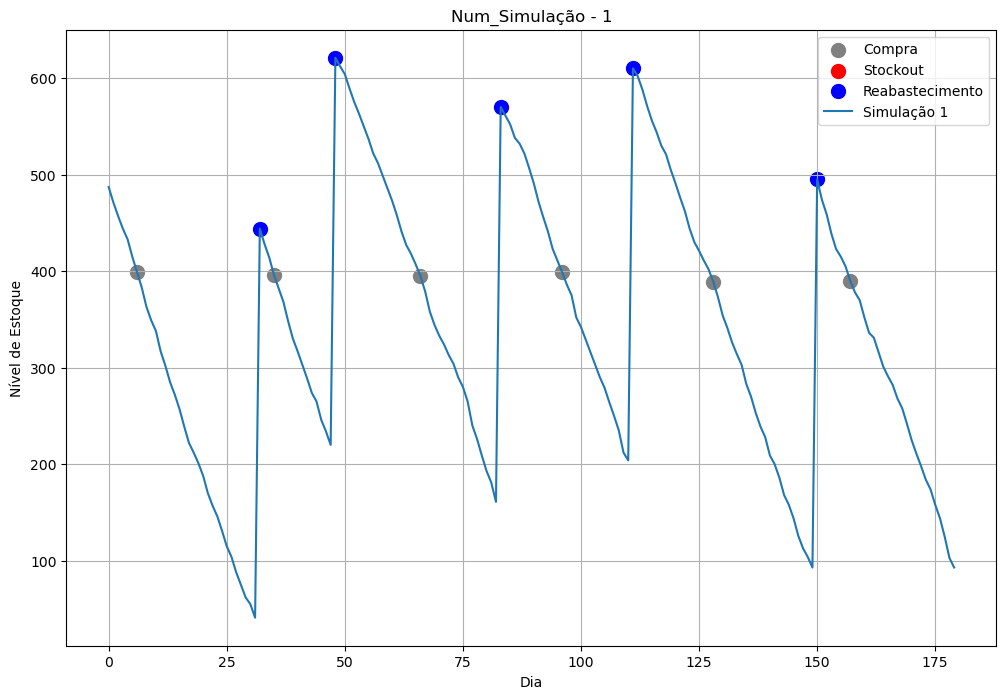

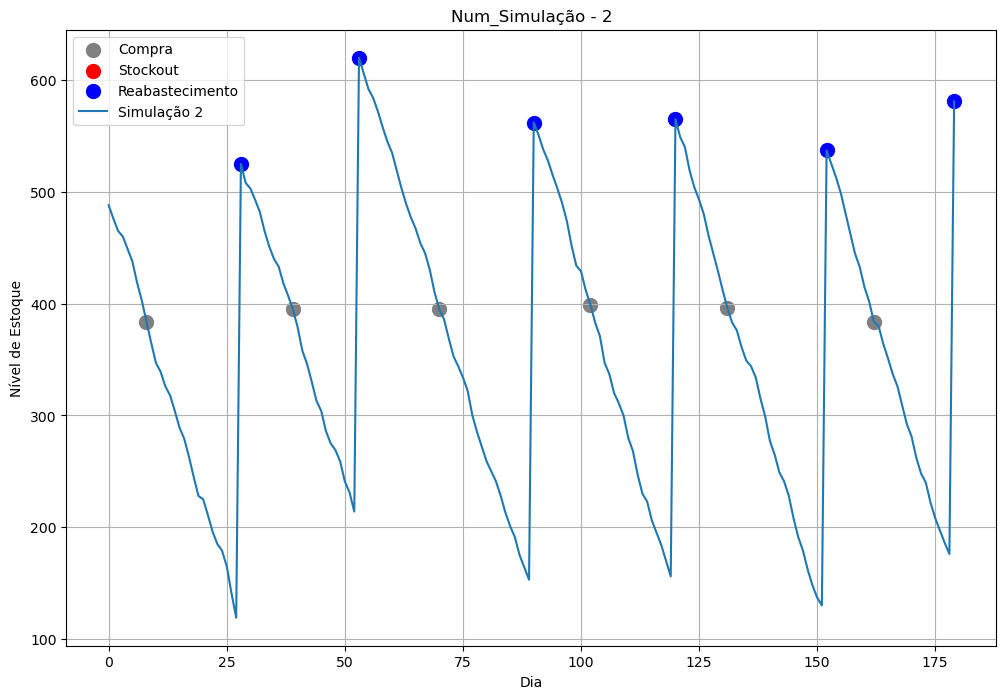

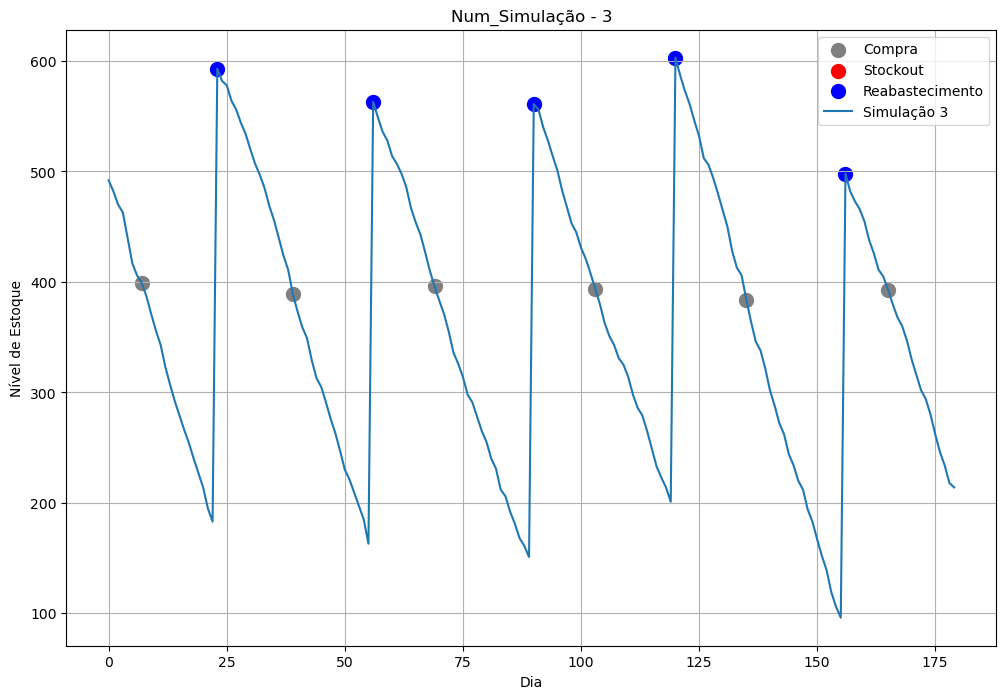

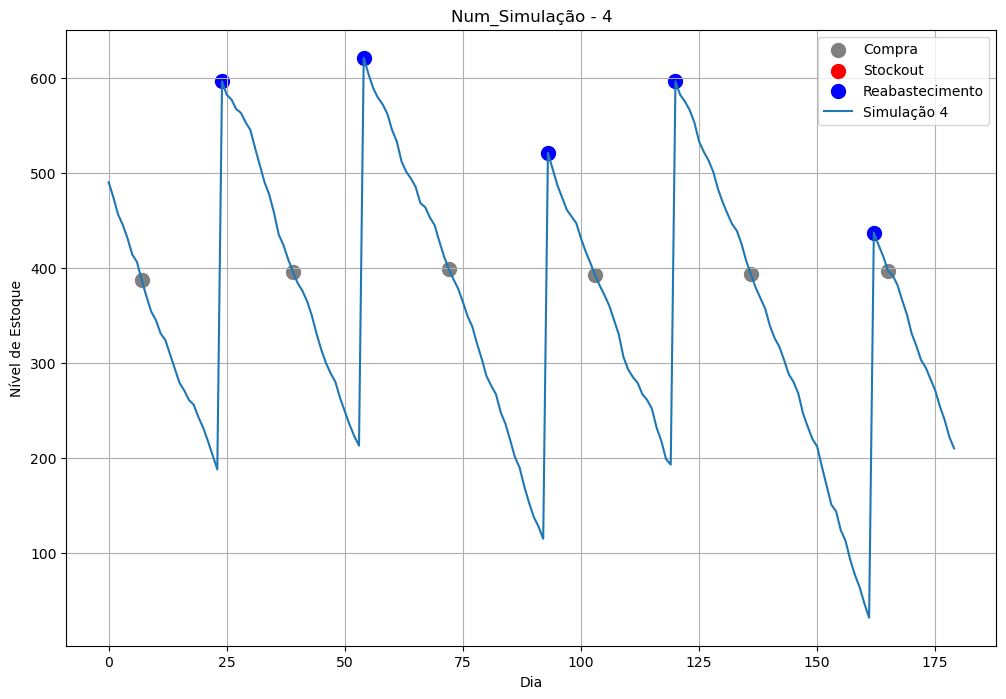

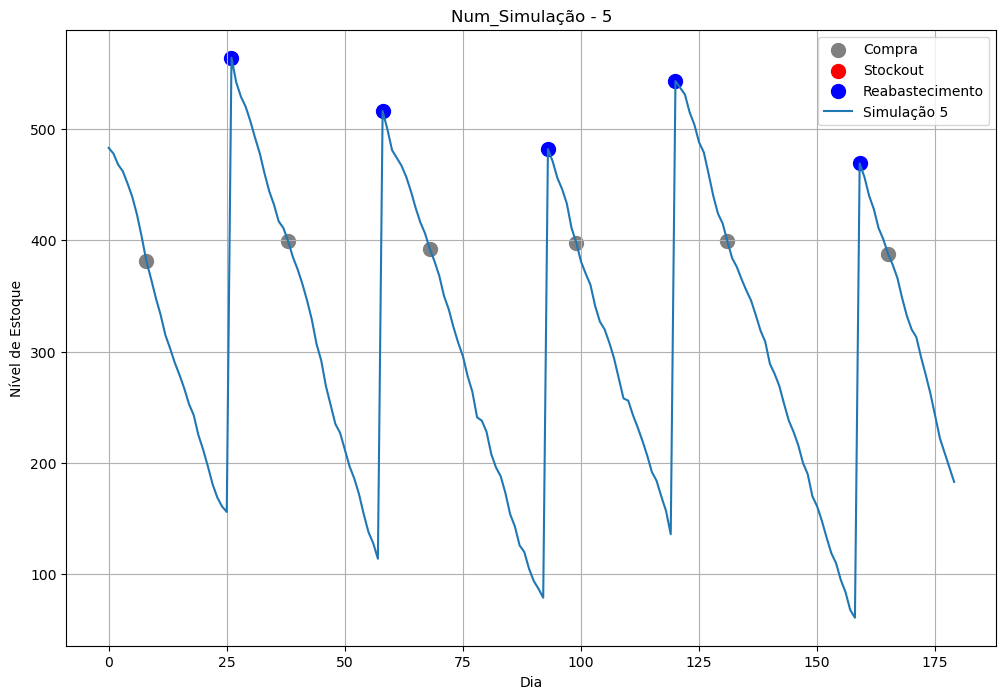

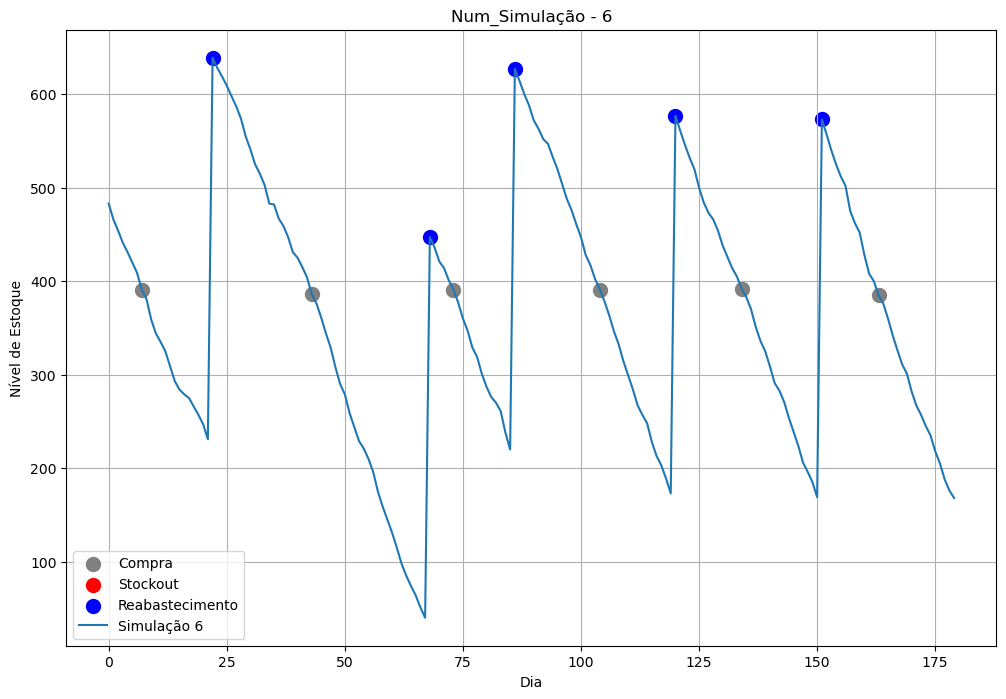

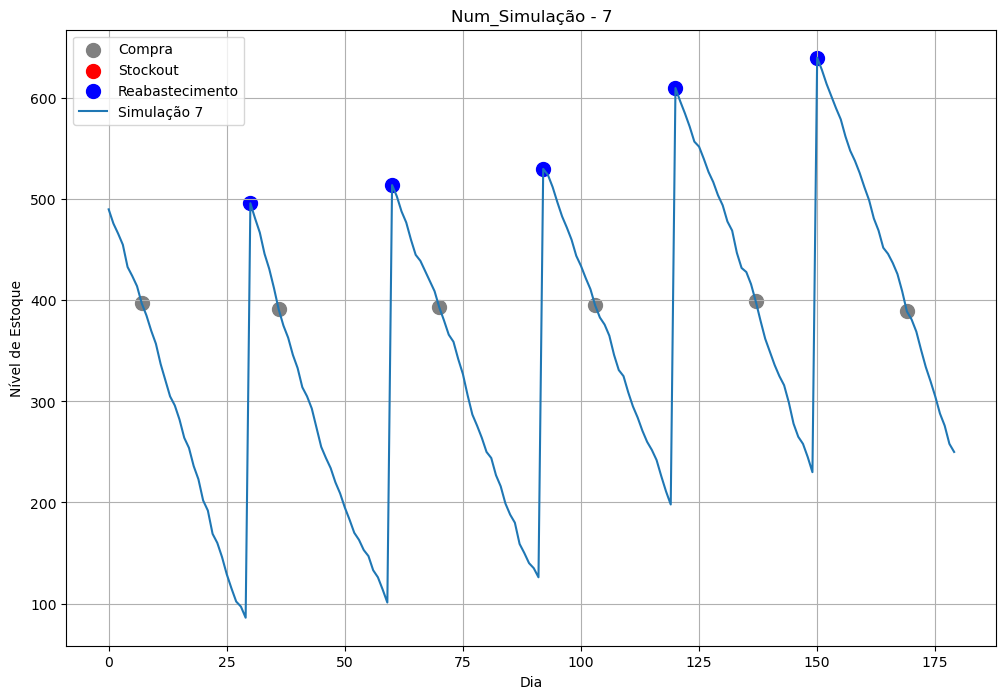

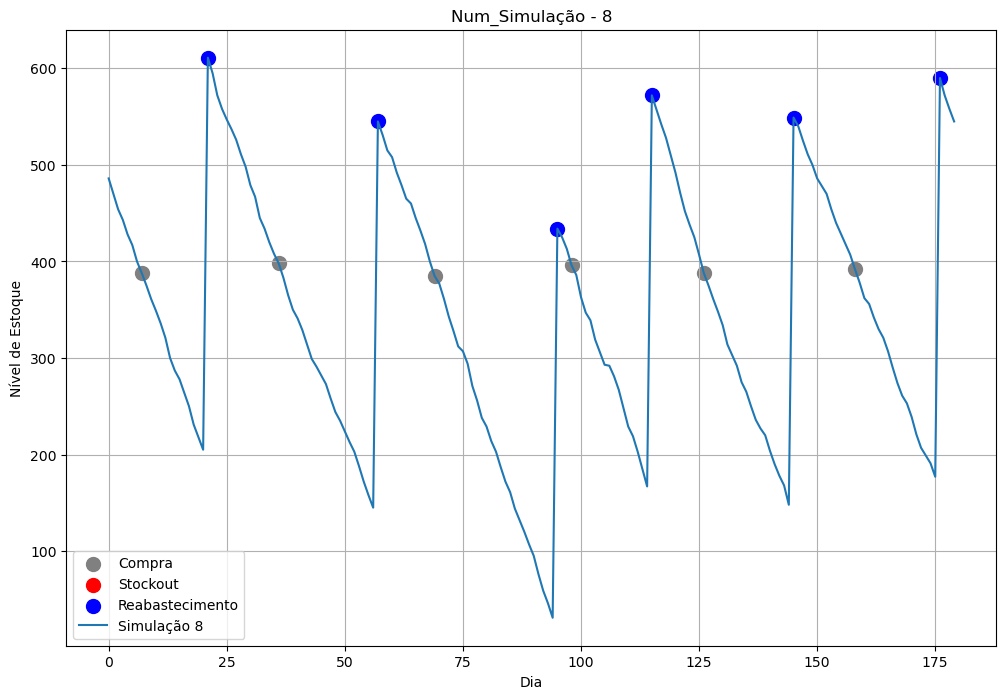

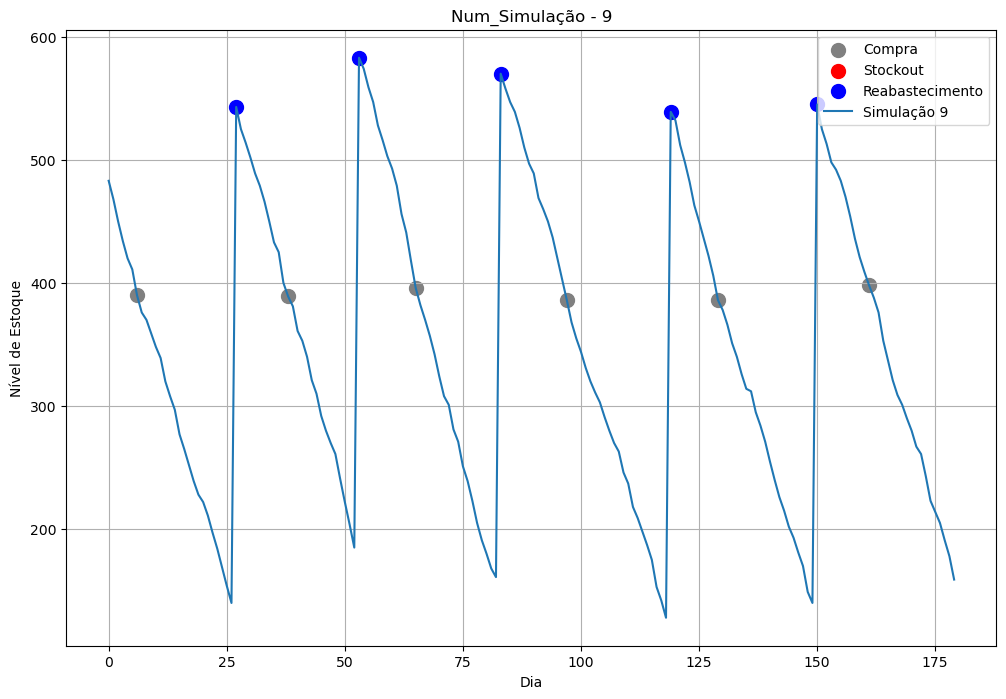

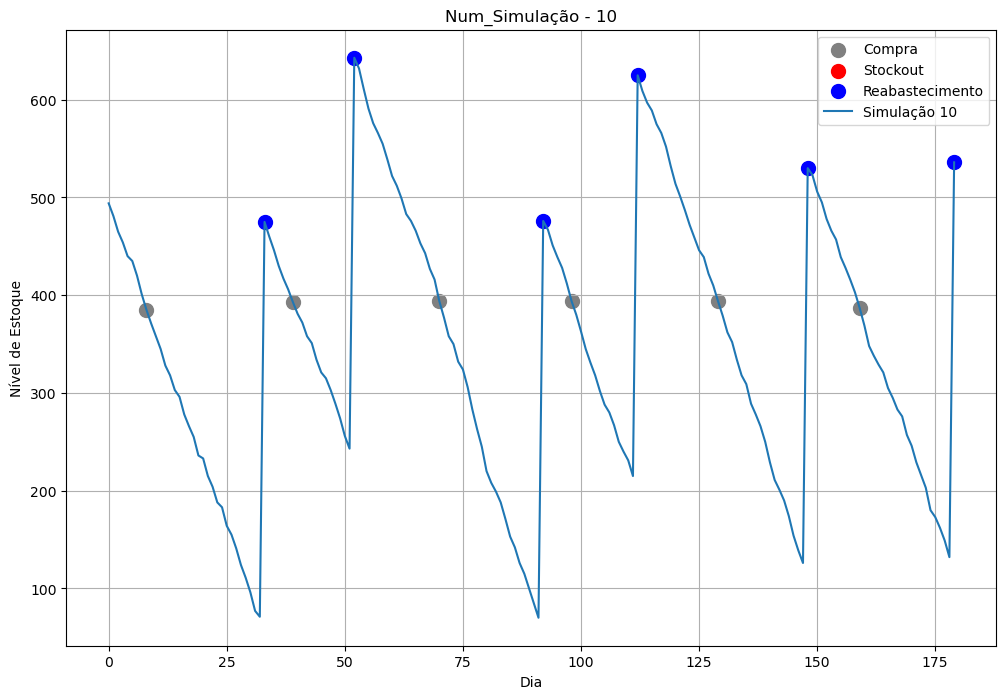

In [200]:
for n_sim in range(1,11):
    plot_simulacoes(df_resultados, n_sim)

- Não foi observado nenhum stockout nas 10 primeiras simulações para as políticas de compras passadas!

## 4.2 Probabilidade geral de Stockout

In [201]:
p_stockout = probabilidade_stockout(df_resultados)
print(f'Considerando todas as simulações a probabilidade de ocorrer stockout é de {round(100*p_stockout,2)}%')

Considerando todas as simulações a probabilidade de ocorrer stockout é de 1.2%


## 4.3 Checando as premissas de demanda e lead time fornecedor
- Variação da demanda
- Variação lead time do fornecedor

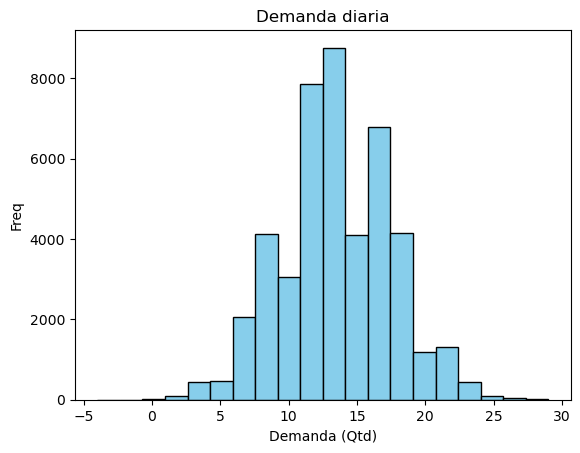

In [202]:
plt.hist(df_resultados['demanda_dia'], bins=20, color='skyblue', edgecolor='black')

plt.title('Demanda diaria')
plt.xlabel('Demanda (Qtd)')
plt.ylabel('Freq')

plt.show()

In [203]:
df_resultados['demanda_dia'].mean(), df_resultados['demanda_dia'].std()

(13.498377777777778, 4.033587185960136)

- Gaussiana com média 13.5 e desvpad 4 como especificado!

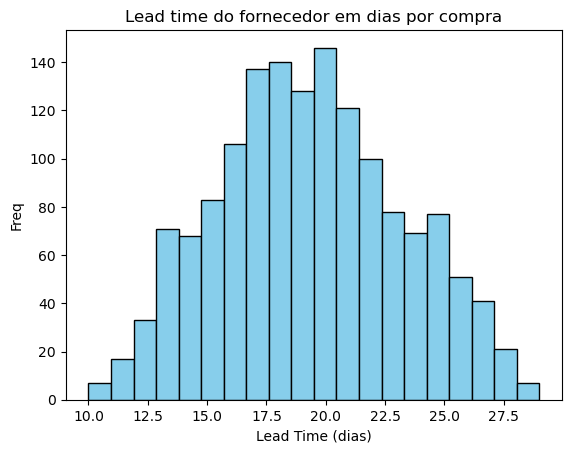

In [204]:
## lead time
df_compras = df_resultados[df_resultados['flag_comprou']==1]  ## Lead time é informado ao comprador no dia da compra

plt.hist(df_compras['lead_time_forn_dia'], bins=20, color='skyblue', edgecolor='black')

plt.title('Lead time do fornecedor em dias por compra')
plt.xlabel('Lead Time (dias)')
plt.ylabel('Freq')

plt.show()

In [205]:
df_compras['lead_time_forn_dia'].mean(), df_compras['lead_time_forn_dia'].max(), df_compras['lead_time_forn_dia'].min(), 

(19.32711525649567, 29.0, 10.0)

Distribuição triangular com dia mais provavel em torno de 20, com min = 10 e max = 30

## 4.4 Visualizando ocorrências de stockouts e número de dias em stockout

In [206]:
df_stockout = df_resultados.groupby(['n_simulacao']).agg(dias_stockout = ('flag_houve_stockout','sum'))
df_stockout = df_stockout.reset_index()
df_stockout.head()

,n_simulacao,dias_stockout
0,1.0,0.0
1,2.0,0.0
2,3.0,0.0
3,4.0,0.0
4,5.0,0.0


In [207]:
df_stockout.groupby('dias_stockout').agg(freq=('n_simulacao','count')).sort_values(by='dias_stockout', ascending=True)

,freq
dias_stockout,
0.0,247
1.0,3


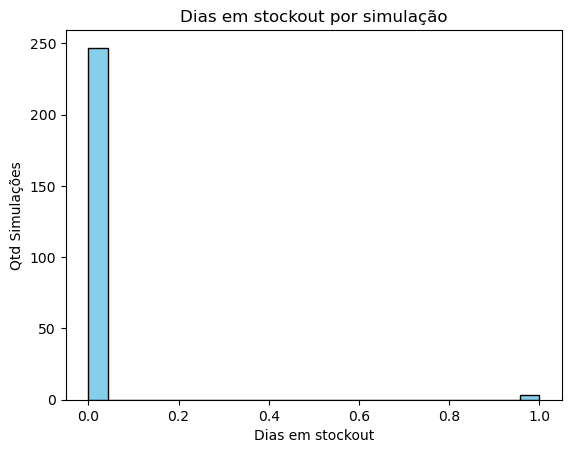

In [208]:
plt.hist(df_stockout['dias_stockout'], bins=23, color='skyblue', edgecolor='black')

plt.title('Dias em stockout por simulação')
plt.xlabel('Dias em stockout')
plt.ylabel('Qtd Simulações')

plt.show()

In [265]:
def calcula_dias_stockout_provavel(df_resultados):
    df_stockout = df_resultados.groupby(['n_simulacao']).agg(dias_stockout = ('flag_houve_stockout','sum'))
    df_stockout = df_stockout.reset_index()

    if len(df_stockout) > 0:
        dias_provaveis_stockout_dado_stockout = df_stockout[df_stockout['dias_stockout']>0].dias_stockout.mean()
    else:
        dias_provaveis_stockout_dado_stockout = 0

    return dias_provaveis_stockout_dado_stockout   

In [266]:
dias_provaveis_stockout_dado_stockout = calcula_dias_stockout_provavel(df_resultados)
p_stockout = probabilidade_stockout(df_resultados)

print(f'Há uma probabilidade de {round(100*p_stockout,2)}% de Stockout.')
print(f'Dado que houve stockout a quantidade de dias mais provável sem abastecimento é de {round(dias_provaveis_stockout_dado_stockout)} dia(s)')

Há uma probabilidade de 1.0% de Stockout.
Dado que houve stockout a quantidade de dias mais provável sem abastecimento é de 1 dia(s)


- A política de compra está bem específicada!

## 4.5 Indicador de  capital preso em estoque e compras 
- Capital preso em estoque e compras = Nível Médio de Estoque + Qtd em transito

In [247]:
def calcula_capital_preso(df_resultados):
    df_resultados['qtd_preso_estoque_ou_compra'] = df_resultados['estoque_dia'] + df_resultados['qtd_compra_acumulada']
    preco_medio = df_resultados.preco_compra.mean()
    qtd_preso_estoque_ou_compra = df_resultados.qtd_preso_estoque_ou_compra.mean()

    kpi_capital_preso = qtd_preso_estoque_ou_compra * preco_medio
    return kpi_capital_preso

In [248]:
kpi_capital_preso = calcula_capital_preso(df_resultados)
print(f'As simulações mostraram que há em média R$ {round(kpi_capital_preso,2)} de capital preso em estoque ou compras')

As simulações mostraram que há em média R$ 4468.07 de capital preso em estoque ou compras


## 5 Alterando cenários de compra para aumentar o capital de giro

- Vamos simular alternativas para a política de compra a fim de aumentarmos o capital de giro da empresa
- Conseguimos aumentar o capital de giro diminuindo o capital preso em estoque
- Vamos alterar duas variáveis de compras e avaliar a probabilidades de stockout para tomada de decisão
- n_dias_reabast e estoque_minimo

In [272]:
n_dias_reabast_testados = [i for i in range(5,30,1)]
estoque_minimo_testados = [i for i in range(200,400,5)]

In [278]:
tot_sim = len(estoque_minimo_testados) * len(n_dias_reabast_testados)
tot_sim

1000

In [274]:
df_riscos_e_capital = pd.DataFrame()

sim = 0

for i in n_dias_reabast_testados:
    for k in estoque_minimo_testados:

        sim = sim + 1

        ## Roda simulação
        df_resultados = simulacao_estoque_montecarlo(
                         num_simulacoes = 100,                  ## Var simulação
                         n_dias = 180,                          ## Var simulação


                         media_demanda_t0 = 14,                 ## Var inicialização da simulação t=0 - Média demanda AS IS
                         desvio_padrao_demanda_t0 = 4,          ## Var inicialização da simulação t=0 - Desvio padrão demanda AS IS
                         qtd_comprada_t0 = 300,                 ## Var inicialização da simulação t=0 - Qtd comprada ultima compra AS IS
                         estoque_t0 = 500,                      ## Var inicialização da simulação t=0 - Nível de estoque AS IS

                         preco_unitario_max = 11.0,             ## Var Fornecedor: Definidos pelo fornecedor se comprar só 1
                         preco_unitario_min = 10.0,             ## Var Fornecedor: Definidos pelo fornecedor descontos extras caso compre o a partir de um máximo definido
                         tempo_reposicao_min = 10,              ## Var Fornecedor: tempo mínimo para entrega
                         tempo_reposicao_max = 30,              ## Var Fornecedor: tempo máximo para entrega
                         tempo_reposicao_most_likely = 20,      ## Var Fornecedor: tempo mais provavel para entrega
                         b = -0.01,                             ## Var fornecedor: controla taxa de decaimento do preço em detrimento da qtd_comprada
                        
                         elasticidade_preco_demanda = None,     ## Var negócio: Elasticidade preco demanda observado para o produto (variacao demanda / variacao preco)
                         n_dias_reabast = i,                    ## Var negócio: Cada compra terá que reabastecer a demanda prevista nos proximos n_dias_reabast ## entre t_max ou tmin forn
                         estoque_minimo = k)                    ## Var negócio: Estoque mínimo para ser triggado uma checagem para realização de uma compra.


        ## Calcula risco de stockout
        p_stockout = probabilidade_stockout(df_resultados)

        ## Calcula capital preso
        kpi_capital_preso = calcula_capital_preso(df_resultados)

        ## Calcula qtd de dias de stockout dado que houve stockout
        dias_provaveis_stockout_dado_stockout = calcula_dias_stockout_provavel(df_resultados)

        ## Armazenando resultados
        df_it = pd.DataFrame(np.array([[i,k,kpi_capital_preso,p_stockout,dias_provaveis_stockout_dado_stockout]]), columns=['n_dias_reabast','estoque_minimo','capital_preso','prob_stockout','dias_em_stockout_provavel'])
        df_riscos_e_capital = pd.concat([df_riscos_e_capital,df_it], ignore_index=True)

        ## Report Status Simulação
        print(f'{sim}/{tot_sim} Concluido')


## Caso prob stocktout seja 0 então dias em stockout tbm deve ser!
df_riscos_e_capital['dias_em_stockout_provavel'] = df_riscos_e_capital['dias_em_stockout_provavel'].fillna(0)


parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
1/1600 Concluido
parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
2/1600 Concluido
parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
3/1600 Concluido
parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
4/1600 Concluido
parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
5/1600 Concluido
parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
6/1600 Concluido
parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
7/1600 Concluido
parâmetro n_dias_reabast = 5 está fora do intervalo tempo_reposicao_min = 10 e tempo_reposicao_max = 30
8/1600 Concluido
parâmetro n_dias_reabast = 5 est

In [280]:
#df_riscos_e_capital.to_parquet('resultados_politicas_compra_vs_capital_gasto_e_risco_stockout.parquet')

# 6 Analise multiplas políticas de compra

In [284]:
df_riscos_e_capital = pd.read_parquet('resultados_politicas_compra_vs_capital_gasto_e_risco_stockout.parquet')
df_riscos_e_capital

,n_dias_reabast,estoque_minimo,capital_preso,prob_stockout,dias_em_stockout_provavel
0,5.0,200.0,3981.310739,0.99,10.333333
1,5.0,205.0,3998.534526,0.97,10.371134
2,5.0,210.0,4051.603273,1.00,9.310000
3,5.0,215.0,4085.833798,0.98,7.938776
4,5.0,220.0,4127.954909,0.92,6.260870
...,...,...,...,...,...
995,29.0,375.0,5833.635000,0.05,1.200000
996,29.0,380.0,5867.981043,0.02,1.500000
997,29.0,385.0,5940.625815,0.02,1.000000
998,29.0,390.0,5981.458359,0.04,1.500000


## 6.1 Estimativa capital perdido por stockout
- Um calculo simples para estimar as perdas por conta de stockout é a probabilidade de stockout * demanda diaria do produto * preco_produto * dias de stockout 

In [295]:
preco_unitario_estimado = df_resultados.preco_compra.mean()
demanda_estimada = df_resultados.demanda_dia.mean()

df_riscos_e_capital['capital_perdido_stockout'] = df_riscos_e_capital['prob_stockout'] *  demanda_estimada * df_riscos_e_capital['dias_em_stockout_provavel'] * preco_unitario_estimado
#df_riscos_e_capital

,n_dias_reabast,estoque_minimo,capital_preso,prob_stockout,dias_em_stockout_provavel,capital_perdido_stockout
0,5.0,200.0,3981.310739,0.99,10.333333,1385.690950
1,5.0,205.0,3998.534526,0.97,10.371134,1362.663827
2,5.0,210.0,4051.603273,1.00,9.310000,1261.073582
3,5.0,215.0,4085.833798,0.98,7.938776,1053.829481
4,5.0,220.0,4127.954909,0.92,6.260870,780.213086
...,...,...,...,...,...,...
995,29.0,375.0,5833.635000,0.05,1.200000,8.127220
996,29.0,380.0,5867.981043,0.02,1.500000,4.063610
997,29.0,385.0,5940.625815,0.02,1.000000,2.709073
998,29.0,390.0,5981.458359,0.04,1.500000,8.127220


## 6.2 Capital total preso ou perdido
- O capital total preso ou perdido é o somatório dos prejuizos por stockout + capital preso em estoque + capital preso em compras em trânsito

In [297]:
df_riscos_e_capital['total_capital_preso_ou_perdido'] = df_riscos_e_capital['capital_preso'] + df_riscos_e_capital['capital_perdido_stockout']
df_riscos_e_capital

,n_dias_reabast,estoque_minimo,capital_preso,prob_stockout,dias_em_stockout_provavel,capital_perdido_stockout,total_capital_preso_ou_perdido
0,5.0,200.0,3981.310739,0.99,10.333333,1385.690950,5367.001689
1,5.0,205.0,3998.534526,0.97,10.371134,1362.663827,5361.198354
2,5.0,210.0,4051.603273,1.00,9.310000,1261.073582,5312.676855
3,5.0,215.0,4085.833798,0.98,7.938776,1053.829481,5139.663278
4,5.0,220.0,4127.954909,0.92,6.260870,780.213086,4908.167995
...,...,...,...,...,...,...,...
995,29.0,375.0,5833.635000,0.05,1.200000,8.127220,5841.762220
996,29.0,380.0,5867.981043,0.02,1.500000,4.063610,5872.044653
997,29.0,385.0,5940.625815,0.02,1.000000,2.709073,5943.334888
998,29.0,390.0,5981.458359,0.04,1.500000,8.127220,5989.585579


## 6.3 Melhores politica de acordo com capital total preso ou perdido

In [384]:
df_plot = df_riscos_e_capital.pivot(index='n_dias_reabast',columns='estoque_minimo',values='total_capital_preso_ou_perdido')
df_plot.head()

estoque_minimo,200.0,205.0,210.0,215.0,220.0,225.0,230.0,235.0,240.0,245.0,...,350.0,355.0,360.0,365.0,370.0,375.0,380.0,385.0,390.0,395.0
n_dias_reabast,,,,,,,,,,,,,,,,,,,,,
5.0,5367.001689,5361.198354,5312.676855,5139.663278,4908.167995,4833.953248,4853.703941,4774.072818,4695.719576,4646.374039,...,5483.741966,5522.065980,5574.486621,5644.973107,5690.113646,5746.343361,5807.903742,5866.767090,5920.597088,5958.705628
6.0,5511.792811,5305.742357,5102.595077,5062.551735,5056.786297,4916.122415,4854.712170,4840.685513,4753.754631,4784.749731,...,5479.619107,5551.773441,5600.083538,5645.131525,5696.183433,5761.647827,5814.572320,5846.333838,5904.434584,5968.136372
7.0,5414.525190,5377.231517,5304.759711,5226.355390,5166.263174,4963.817181,4907.445307,5008.710489,4804.909842,4809.109291,...,5494.259233,5550.394985,5608.495386,5668.995211,5711.760886,5744.303490,5807.380405,5861.173467,5928.034103,5945.852257
8.0,5534.134688,5453.728156,5401.054254,5172.953349,5164.610054,5099.346845,5046.345641,4963.850062,4901.218630,4838.950554,...,5475.174085,5531.086515,5604.830895,5659.239548,5701.040540,5762.175353,5819.513334,5876.456753,5921.383949,5976.542002
9.0,5727.366082,5465.944014,5526.694582,5293.385711,5154.241322,5172.850741,5086.913911,5007.360912,5033.684653,4942.381013,...,5502.525299,5566.995586,5635.983669,5674.034473,5718.212979,5753.430407,5809.491410,5890.324902,5952.230448,5981.259184


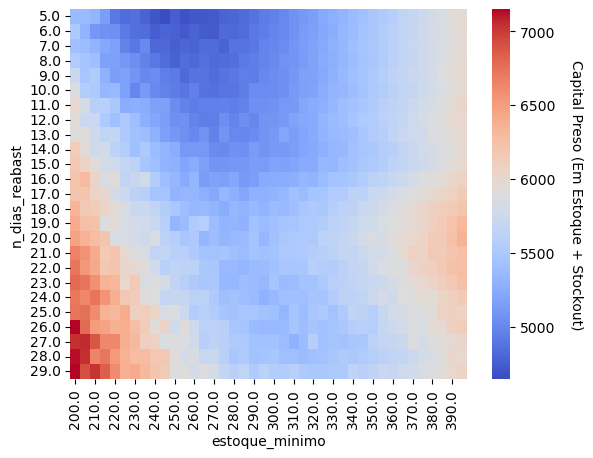

In [390]:
heatmap = sns.heatmap(df_plot, annot=False, cmap="coolwarm")
cbar = heatmap.collections[0].colorbar
cbar.set_label('Capital Preso (Em Estoque + Stockout)', rotation=270, labelpad=20)

In [311]:
best_n_dias_reabast = df_riscos_e_capital[df_riscos_e_capital['total_capital_preso_ou_perdido'] == df_riscos_e_capital.total_capital_preso_ou_perdido.min()].n_dias_reabast.values[0]
best_estoque_minimo = df_riscos_e_capital[df_riscos_e_capital['total_capital_preso_ou_perdido'] == df_riscos_e_capital.total_capital_preso_ou_perdido.min()].estoque_minimo.values[0]

print(f'A melhor política de compra nesse cenário e n_dias_reabastecimento = {best_n_dias_reabast} e estoque mínimo = {best_estoque_minimo}')

A melhor política de compra nesse cenário e n_dias_reabastecimento = 5.0 e estoque mínimo = 245.0


- A melhor área para se operar as políticas de compra é com estoque mínimo entre 210 á 270 e quantidade a ser comprada suficiente para abastecer 5 á 6 dias de demanda.
- Contudo, essa pode não ser as melhores especificações de política de compras, pois estamos desconsiderando 2 efeitos:

        1) Com compras mais frequentes há maior tempo alocado para realização de compras, esse tempo não entrou no indicador de capital gasto;  
        2) Elasticidade Preço-Demanda: Ao comprar em menor quantidade o fornecedor pode aumentar seus preços. O preço reajustado será repassado ao consumidor final e impactará na diminuição da produto. Não estamos considerando esse efeito pois passamos o parâmetro elasticidade = None nas simulações.  

## 6.4 Melhores politicas de acordo com risco de stockout

In [391]:
df_plot = df_riscos_e_capital.pivot(index='n_dias_reabast',columns='estoque_minimo',values='prob_stockout')
df_plot.head()

estoque_minimo,200.0,205.0,210.0,215.0,220.0,225.0,230.0,235.0,240.0,245.0,...,350.0,355.0,360.0,365.0,370.0,375.0,380.0,385.0,390.0,395.0
n_dias_reabast,,,,,,,,,,,,,,,,,,,,,
5.0,0.99,0.97,1.00,0.98,0.92,0.94,0.88,0.87,0.75,0.70,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
6.0,1.00,0.99,0.99,0.98,0.97,0.98,0.87,0.88,0.81,0.73,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
7.0,1.00,1.00,1.00,0.99,0.95,0.91,0.93,0.92,0.84,0.79,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
8.0,1.00,0.99,0.97,0.99,0.96,0.93,0.97,0.94,0.93,0.84,...,0.0,0.01,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0
9.0,1.00,0.99,0.98,0.97,0.99,0.97,0.98,0.93,0.88,0.84,...,0.0,0.01,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0


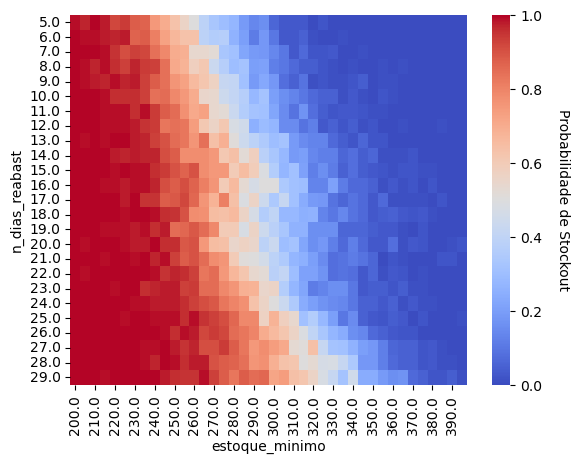

In [392]:
heatmap = sns.heatmap(df_plot, annot=False, cmap="coolwarm"  )
cbar = heatmap.collections[0].colorbar
cbar.set_label('Probabilidade de Stockout', rotation=270, labelpad=20)

- A operação atualmente, ocorre com n_dias_reabast = 30 e estoque_mínimo = 400 e opera com 1% de stockout, outras opções semelhantes seriam as destacadas em azul e branco

In [367]:
df_stockout_menorigual_atual = df_riscos_e_capital[df_riscos_e_capital['prob_stockout']<=0.01]
df_plot = df_stockout_menorigual_atual.pivot(index='n_dias_reabast',columns='estoque_minimo',values='prob_stockout')
df_plot.head()

estoque_minimo,320.0,325.0,330.0,335.0,340.0,345.0,350.0,355.0,360.0,365.0,370.0,375.0,380.0,385.0,390.0,395.0
n_dias_reabast,,,,,,,,,,,,,,,,
5.0,0.00,NaN,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.01,0.0,0.00,0.01,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
7.0,NaN,NaN,NaN,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
8.0,NaN,NaN,0.01,0.00,0.01,0.00,0.0,0.01,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.01,NaN,0.01,0.01,NaN,NaN,0.0,0.01,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='estoque_minimo', ylabel='n_dias_reabast'>

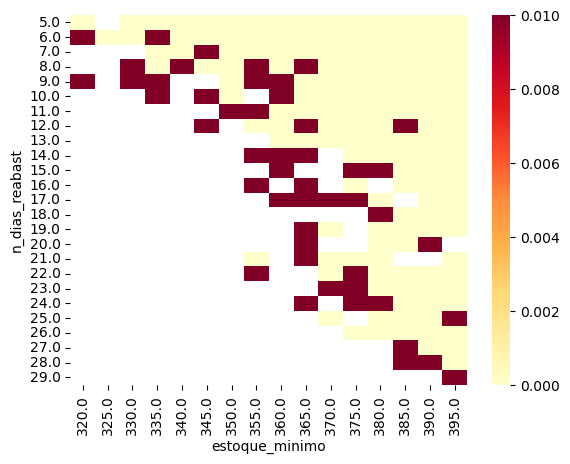

In [383]:
sns.heatmap(df_plot, annot=False, cmap="YlOrRd" )

- Esses são os pontos de operação com risco <= 1% de stockout

# Conclusões

- 